# **Penjelasan Dataset yang digunakan**

## 1. Kasus yang diambil
Analisis ini mengambil kasus sentimen dari data Twitter. Dataset berisi kumpulan tweet yang sudah diberi label sentimen seperti Positive, Negative, Neutral, dan Irrelevant. Tujuan analisis adalah untuk memprediksi sentimen suatu teks menggunakan algoritma Machine Learning yang saya pilih yaitu Support Vector Machine(SVM).

## 2. Penjelasan setiap kolom
### Kolom 1 : ID tweet
### Kolom 2 : Kategori (topik atau entitas terkait)
### Kolom 3 : Sentimen (label sentimen yang akan diprediksi)
### Kolom 4 : Text (isi dari tweet yang dianalisis)

## 3. Import Library

In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
data = pd.read_csv('/content/twitter_training.csv', header=None)

# Ganti nama kolom agar mudah dipahami
data.columns = ['id', 'category', 'sentiment', 'text']

# Ambil hanya kolom penting (sentimen dan teks)
data = data[['sentiment', 'text']]

# Hapus baris kosong
data = data.dropna()

# Tampilkan 5 data pertama
data.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


# **Data Understanding**

Jumlah total data: 73996
Panjang rata-rata setiap baris (jumlah kata): 19.23
Jumlah data duplikat: 4227

Jumlah data kosong per kolom:
sentiment            0
text                 0
text_length          0
tokens               0
lemmatized           0
stemmed              0
clean_tokens         0
clean_text           0
label                0
clean_text_length    0
dtype: int64


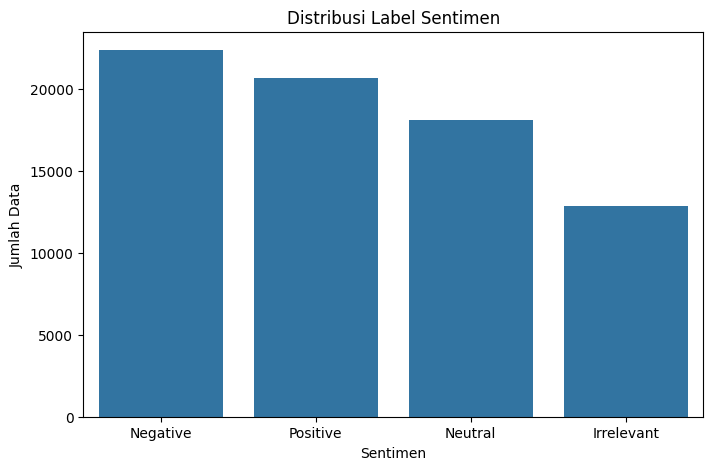

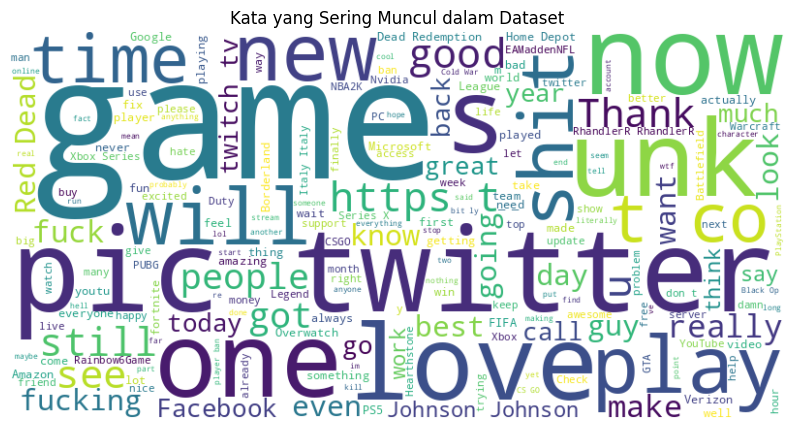

In [34]:
# 1. Jumlah baris data
print("Jumlah total data:", len(data))

# 2. Panjang rata-rata setiap baris teks
data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))
rata_rata_panjang = data['text_length'].mean()
print("Panjang rata-rata setiap baris (jumlah kata):", round(rata_rata_panjang, 2))

# 3. Cek data duplikasi
# Exclude list columns when checking for duplicates
columns_to_check = [col for col in data.columns if col not in ['tokens', 'lemmatized', 'stemmed', 'clean_tokens']]
jumlah_duplikat = data.duplicated(subset=columns_to_check).sum()
print("Jumlah data duplikat:", jumlah_duplikat)

# 4. Cek data kosong
print("\nJumlah data kosong per kolom:")
print(data.isnull().sum())

# 5. Distribusi data
# a. Distribusi jumlah label sentimen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', data=data, order=data['sentiment'].value_counts().index)
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.show()

# b. Word Cloud kata yang sering muncul
from wordcloud import WordCloud

# Gabungkan semua teks
all_text = ' '.join(data['text'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata yang Sering Muncul dalam Dataset')
plt.show()

##Model Training (SVM)

In [22]:
from sklearn.svm import LinearSVC

# Latih model Linear SVC
model = LinearSVC()
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


##Model Evaluation

Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.72      0.56      0.63      2696
    Negative       0.74      0.78      0.76      4380
     Neutral       0.65      0.67      0.66      3605
    Positive       0.69      0.75      0.72      4119

    accuracy                           0.70     14800
   macro avg       0.70      0.69      0.69     14800
weighted avg       0.70      0.70      0.70     14800


Confusion Matrix:


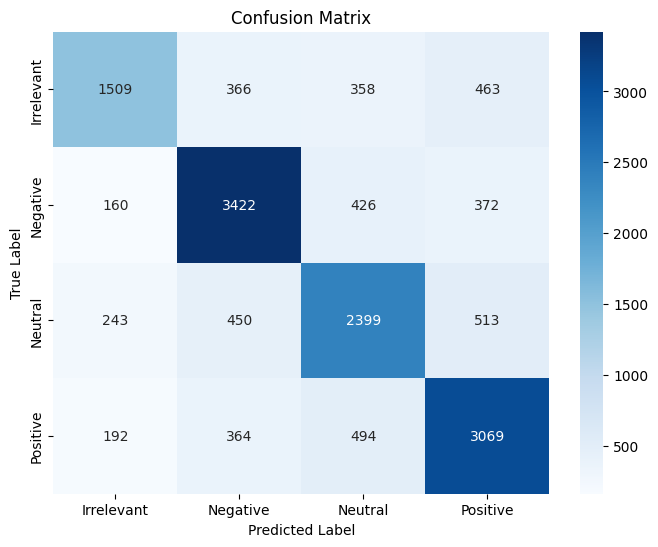

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prediksi pada data test
y_pred = model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=encoder.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Model Prediction

In [24]:
# Contoh prediksi pada data baru
def predict_sentiment(text):
    # Preprocess the text
    tokens = word_tokenize(str(text).lower())
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    stemmed = [stemmer.stem(word) for word in lemmatized]
    clean_tokens = [word for word in stemmed if word.isalpha() and word not in stop_words]
    clean_text = ' '.join(clean_tokens)

    # Vectorize the text
    text_vector = tfidf.transform([clean_text])

    # Predict the sentiment
    prediction = model.predict(text_vector)
    predicted_label = encoder.inverse_transform(prediction)[0]

    return predicted_label

# Contoh penggunaan
new_tweet1 = "I am so happy with this product!"
new_tweet2 = "This is the worst customer service ever."
new_tweet3 = "The weather is neutral today."
new_tweet4 = "This is an irrelevant tweet."


print(f"Sentiment of '{new_tweet1}': {predict_sentiment(new_tweet1)}")
print(f"Sentiment of '{new_tweet2}': {predict_sentiment(new_tweet2)}")
print(f"Sentiment of '{new_tweet3}': {predict_sentiment(new_tweet3)}")
print(f"Sentiment of '{new_tweet4}': {predict_sentiment(new_tweet4)}")

Sentiment of 'I am so happy with this product!': Positive
Sentiment of 'This is the worst customer service ever.': Negative
Sentiment of 'The weather is neutral today.': Positive
Sentiment of 'This is an irrelevant tweet.': Irrelevant


The chosen model for this sentiment analysis task is a **Linear Support Vector Machine (LinearSVC)**.

**Why LinearSVC?**

LinearSVC is a suitable choice for text classification problems like sentiment analysis due to the following reasons:

1.  **Efficiency with High-Dimensional Data:** Text data, when vectorized using techniques like TF-IDF, often results in a high-dimensional feature space. LinearSVC is known for its efficiency and performance in such high-dimensional settings.
2.  **Linear Separability:** SVMs work by finding a hyperplane that best separates different classes in the feature space. LinearSVC assumes that the data is linearly separable, which can be a reasonable assumption for many text classification tasks after effective text preprocessing and feature extraction.
3.  **Good Performance:** LinearSVC often provides good performance and accuracy in text classification benchmarks.
4.  **Interpretability (to some extent):** While not as directly interpretable as models like decision trees, the coefficients of the linear model in LinearSVC can provide some insights into which features (words or terms) are most important for classifying each sentiment.

In this implementation, we used `sklearn.svm.LinearSVC` with default parameters. The model was trained on the TF-IDF transformed training data (`X_train`, `y_train`) to learn the relationship between the text features and the sentiment labels.

# **Data Text Processing**

## 1. Tokenisasi

In [25]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

nltk.download('punkt_tab')


data['tokens'] = data['text'].apply(lambda x: word_tokenize(str(x).lower()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Lemmatization

In [26]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Stemming

In [27]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
data['stemmed'] = data['lemmatized'].apply(lambda x: [stemmer.stem(word) for word in x])

## 4. Stopword removal (hapus tanda baca, angka, dan kata umum

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,im getting on borderlands and i will murder yo...,im get borderland murder
1,I am coming to the borders and I will kill you...,come border kill
2,im getting on borderlands and i will kill you ...,im get borderland kill
3,im coming on borderlands and i will murder you...,im come borderland murder
4,im getting on borderlands 2 and i will murder ...,im get borderland murder


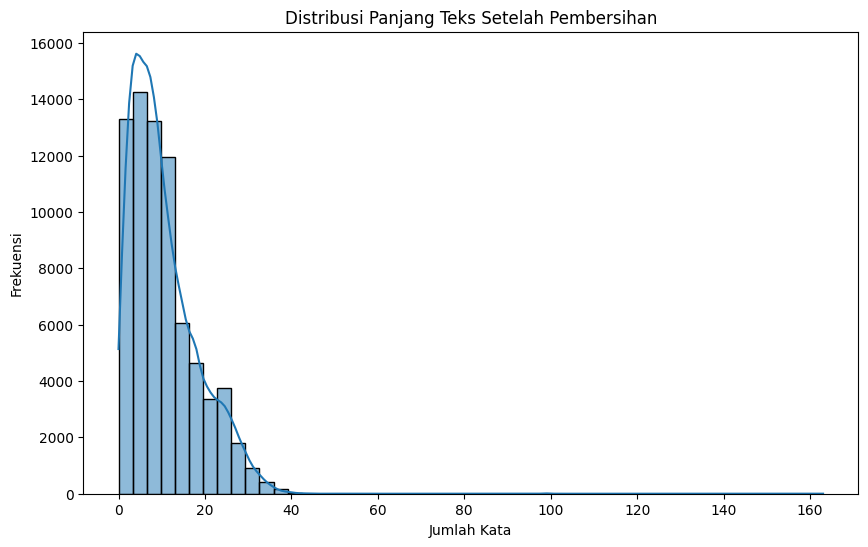

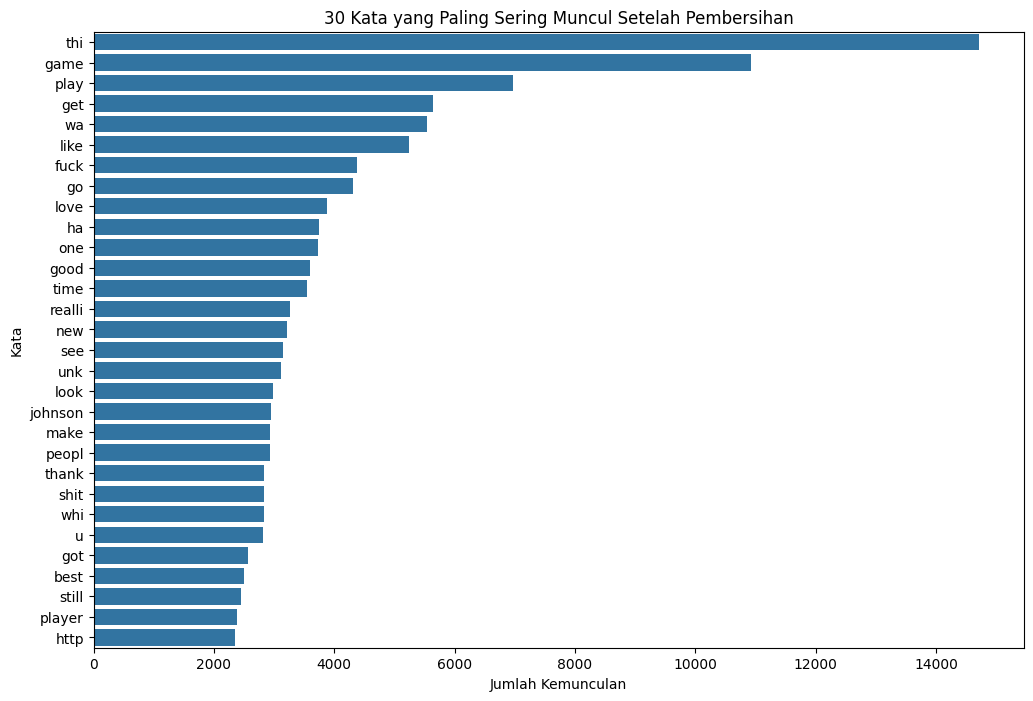

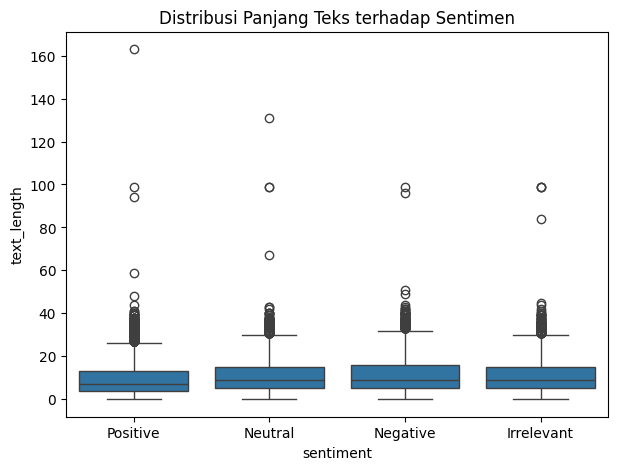

Mapping Label Sentimen:
Irrelevant → 0
Negative → 1
Neutral → 2
Positive → 3
Shape matrix TF-IDF: (73996, 5000)
Jumlah data train: 59196
Jumlah data test: 14800


In [28]:
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    return [word for word in tokens if word.isalpha() and word not in stop_words]

data['clean_tokens'] = data['stemmed'].apply(clean_tokens)

# 5. Text Normalisasi (gabungkan kembali jadi teks bersih)
data['clean_text'] = data['clean_tokens'].apply(lambda x: ' '.join(x))

# Lihat hasil contoh
display(data[['text', 'clean_text']].head())

# Visualisasi: Distribusi panjang teks setelah pembersihan
data['clean_text_length'] = data['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['clean_text_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Teks Setelah Pembersihan')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

# Visualisasi: Kata-kata yang paling sering muncul setelah pembersihan
all_clean_words = [word for tokens in data['clean_tokens'] for word in tokens]
word_counts = Counter(all_clean_words)
most_common_words = word_counts.most_common(30)

most_common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=most_common_words_df)
plt.title('30 Kata yang Paling Sering Muncul Setelah Pembersihan')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Kata')
plt.show()

# 6. Matrix correlation

# (Bagian ini bisa dilewati, tapi contoh sederhana: lihat korelasi panjang teks vs sentimen)
import matplotlib.pyplot as plt

data['text_length'] = data['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,5))
sns.boxplot(x='sentiment', y='text_length', data=data)
plt.title('Distribusi Panjang Teks terhadap Sentimen')
plt.show()

# 7. Labeling data (ubah sentimen jadi angka)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['sentiment'])

print("Mapping Label Sentimen:")
for i, label in enumerate(encoder.classes_):
    print(f"{label} → {i}")

# 8. Text Vektorisasi (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['clean_text'])
y = data['label']

print("Shape matrix TF-IDF:", X.shape)

# 9. Data Splitting
from sklearn.model_selection import train_test_split

# Gunakan skala 0.8 : 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Jumlah data train:", X_train.shape[0])
print("Jumlah data test:", X_test.shape[0])

## 5. Text Normalisasi

In [29]:
data['clean_text'] = data['clean_tokens'].apply(lambda x: ' '.join(x))
# Lihat hasil contoh
display(data[['text', 'clean_text']].head())

,text,clean_text
0,im getting on borderlands and i will murder yo...,im get borderland murder
1,I am coming to the borders and I will kill you...,come border kill
2,im getting on borderlands and i will kill you ...,im get borderland kill
3,im coming on borderlands and i will murder you...,im come borderland murder
4,im getting on borderlands 2 and i will murder ...,im get borderland murder


## 6. Matrix Correlation

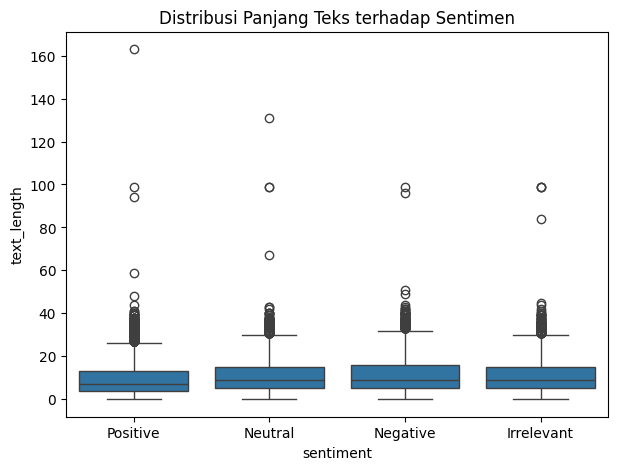

In [30]:
import matplotlib.pyplot as plt

data['text_length'] = data['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,5))
sns.boxplot(x='sentiment', y='text_length', data=data)
plt.title('Distribusi Panjang Teks terhadap Sentimen')
plt.show()


## 7. Labeling Data

In [31]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['sentiment'])

print("Mapping Label Sentimen:")
for i, label in enumerate(encoder.classes_):
    print(f"{label} → {i}")

Mapping Label Sentimen:
Irrelevant → 0
Negative → 1
Neutral → 2
Positive → 3


## 8. Text Vektorisasi

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['clean_text'])
y = data['label']

print("Shape matrix TF-IDF:", X.shape)

Shape matrix TF-IDF: (73996, 5000)


## 9.Data Splitting

In [33]:
from sklearn.model_selection import train_test_split

# Gunakan skala 0.8 : 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Jumlah data train:", X_train.shape[0])
print("Jumlah data test:", X_test.shape[0])

Jumlah data train: 59196
Jumlah data test: 14800


# **Data Modeling**

Model yang digunakan dalam analisis sentimen ini adalah **Support Vector Machine (SVM)**.
SVM merupakan algoritma supervised learning yang digunakan untuk klasifikasi dan regresi.
Tujuan utama SVM adalah mencari *hyperplane* terbaik yang dapat memisahkan data dari kelas berbeda
dengan margin yang paling lebar.

Keunggulan SVM:
1. Cocok untuk data berdimensi tinggi (seperti hasil TF-IDF pada teks).
2. Tidak mudah overfitting pada data kecil atau menengah.
3. Mampu menghasilkan akurasi tinggi dalam klasifikasi teks dan sentimen.

Dalam penelitian ini, digunakan implementasi **LinearSVC** dari scikit-learn,
yang merupakan versi efisien dari SVM untuk kasus linear (banyak fitur, tapi sedikit data relatif).

Akurasi Model SVM: 0.7026

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.72      0.56      0.63      2696
    Negative       0.74      0.78      0.76      4380
     Neutral       0.65      0.67      0.66      3605
    Positive       0.69      0.75      0.72      4119

    accuracy                           0.70     14800
   macro avg       0.70      0.69      0.69     14800
weighted avg       0.70      0.70      0.70     14800



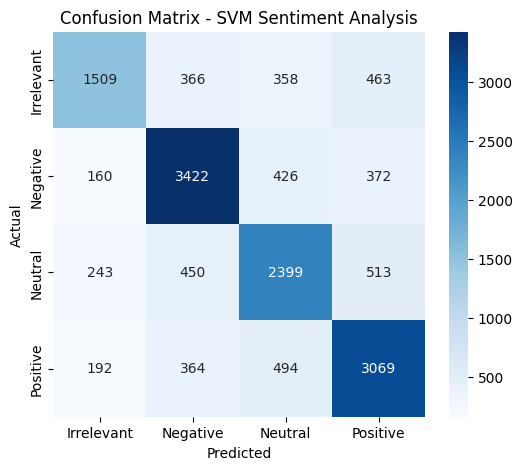

In [38]:
# 1. Membuat dan Melatih Model SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inisialisasi model
svm_model = LinearSVC()

# Melatih model dengan data train
svm_model.fit(X_train, y_train)

# 2. Prediksi Data Test
y_pred = svm_model.predict(X_test)

# 3. Evaluasi Model
print("Akurasi Model SVM:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - SVM Sentiment Analysis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Data Prediksi**

In [37]:
# Contoh input teks
contoh_teks = [
    "I love this product, it works perfectly!",
    "This is the worst service ever!",
    "It was okay, not too bad but not great either."
]

# Preprocessing input baru (mengikuti langkah sebelumnya)
def preprocess_input(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    clean_text = ' '.join(tokens)
    return clean_text

# Bersihkan teks baru
cleaned_input = [preprocess_input(t) for t in contoh_teks]

# Ubah ke bentuk TF-IDF
input_tfidf = tfidf.transform(cleaned_input)

# Prediksi menggunakan model SVM
predictions = svm_model.predict(input_tfidf)

# Konversi label angka ke nama sentimen
hasil_prediksi = encoder.inverse_transform(predictions)

# Tampilkan hasil
for teks, sentimen in zip(contoh_teks, hasil_prediksi):
    print(f"Teks : {teks}")
    print(f"Prediksi Sentimen : {sentimen}")
    print("-" * 60)


Teks : I love this product, it works perfectly!
Prediksi Sentimen : Positive
------------------------------------------------------------
Teks : This is the worst service ever!
Prediksi Sentimen : Negative
------------------------------------------------------------
Teks : It was okay, not too bad but not great either.
Prediksi Sentimen : Negative
------------------------------------------------------------


## Kesimpulan dan Hasil Model SVM untuk Analisis Sentimen

Berdasarkan hasil pengujian menggunakan **Support Vector Machine (SVM)** pada dataset *Twitter Training*, diperoleh hasil evaluasi sebagai berikut:

- **Akurasi Model:** `0.7026` atau sekitar **70.26%**  
- **Precision (rata-rata tertimbang):** 0.70  
- **Recall (rata-rata tertimbang):** 0.70  
- **F1-Score (rata-rata tertimbang):** 0.70  


### Analisis Hasil
1. Model menunjukkan performa cukup baik dengan akurasi di atas 70%, menandakan bahwa SVM mampu mengklasifikasikan sentimen tweet ke dalam empat kategori utama — *Irrelevant, Negative, Neutral,* dan *Positive* — dengan tingkat kesalahan yang relatif kecil.  
2. Sentimen **Negative** memiliki performa tertinggi (precision = 0.74, recall = 0.78), menunjukkan model paling mudah mengenali tweet bernada negatif.  
3. Sentimen **Irrelevant** memiliki nilai recall terendah (0.56), menandakan model sedikit kesulitan membedakan tweet yang tidak relevan dengan kategori lain.  
4. Nilai **macro average dan weighted average** yang konsisten (sekitar 0.70) menunjukkan model cukup stabil pada berbagai kelas sentimen.


### Kesimpulan Akhir
Model **SVM (Support Vector Machine)** efektif untuk analisis sentimen pada data teks pendek seperti tweet.  
Dengan akurasi 70%, model ini sudah dapat digunakan untuk **analisis awal opini publik** atau **monitoring media sosial**, meskipun masih bisa ditingkatkan lagi melalui:
- Penambahan data training yang lebih banyak,  
- Penggunaan *tuning hyperparameter (C, kernel)*,  
- Atau kombinasi metode *deep learning* untuk perbandingan performa.  


